In [ ]:

    # Model Development (ModelDevelopment.ipynb)


    #     Data preprocessing steps
    #     Incremental model training demonstrations using SGD
    #     Model evaluation (cross-validation, live metrics)
    #     Decision on model parameters and final model selection
    #     Discussions on potential production issues, e.g., model drift, retraining strategies

In [62]:
import os

project_directory = '/home/matias/repos/xtream-ai-assignment-engineer'

# Change the current working directory
os.chdir(project_directory)


### 1. Data Preprocessing Steps

- **Objective**: Prepare the diamonds dataset for modeling.
- **Subsections**:
  - **Data Cleaning**: Handling missing values, removing outliers, and correcting errors.
  - **Feature Engineering**: Creating new features that might help improve model performance, such as polynomial features for carat weight, or categorizing diamonds based on their dimensions.
  - **Data Transformation**: Scaling numeric data, encoding categorical variables.
  - **Data Visualization**: Visualizing distributions and relationships to understand the data better and guide further preprocessing steps.


In [100]:
import pandas as pd
import numpy as np

def simulate_new_observations(data, size, label, proportion_factor, save=False):
    """
    Simulates new observations by sampling from the existing dataset and adjusting the prices based on labels.

    Parameters:
        data (DataFrame): The original dataset.
        size (int): Number of samples to generate.
        label (str): Label to assign to the new samples ('special', 'bad quality', etc.).
        proportion_factor (float): Factor to adjust the prices (2 for doubling, 0.5 for halving).
        save (bool): Option to save the modified dataset to a CSV file.

    Returns:
        DataFrame: A new dataset with adjusted prices and labels.
    """
    # Randomly sample 'size' observations from the original dataset
    new_data = data.sample(n=size, random_state=42).reset_index(drop=True)

    # Add a new column 'Label' and assign the given label
    new_data['Label'] = label

    # Adjust the prices based on the label and proportion_factor
    new_data['price'] = new_data['price'] * proportion_factor

    # Save the new dataset if requested
    if save:
        file_name = f'datasets/modified_{label}_{int(proportion_factor*100)}.csv'
        new_data.to_csv(file_name, index=False)
        print(f"Dataset saved as {file_name}")

    return new_data


In [112]:

# Example usage:
data = pd.read_csv('datasets/diamonds/diamonds.csv')
data = data.loc[data.price > 0]  # Ensure no zero or negative prices


In [174]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# # Load data
# data = pd.read_csv('datasets/diamonds/diamonds.csv')
# data = data.loc[data.price > 0]

def preprocess_data(data):
    """
    Preprocesses the input data by transforming the target variable and applying feature transformations.

    Parameters:
        data (DataFrame): The input dataset.

    Returns:
        DataFrame: The preprocessed dataset.
    """

    # Transform 'price' to log10(price)
    data['log_price'] = np.log10(data['price'])

    # Separate transformed target variable 'y' (log_price) and features 'X'
    y = data['log_price']
    X = data.drop(columns=['price', 'log_price'])  # Remove original price to avoid leakage

    # Numeric and categorical features
    numeric_features = ['carat', 'depth', 'table', 'x', 'y', 'z']

    categorical_features = ['cut', 'color', 'clarity', 'Label'] if 'Label' in X.columns else ['cut', 'color', 'clarity']

    # Numeric features adjustments
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('power', PowerTransformer(method='yeo-johnson'))
    ])

    # Categorical features adjustments
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder())
    ])

    # Combine transformations
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

    # Apply preprocessing
    X_preprocessed = preprocessor.fit_transform(X)
    joblib.dump(preprocessor, 'models/preprocessor.joblib')

    # Optionally, convert the output back to a DataFrame
    columns_transformed = (numeric_features + 
                            list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)))
    X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=columns_transformed)
    
    return X_preprocessed, y

X, y = preprocess_data(data)


In [175]:
# TRANSFORMATION PAIRPLOTS


# raw = data[numeric_features]

# trsf = pd.DataFrame(X_preprocessed[:, :6], columns = numeric_features)

# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd

# # Assuming 'raw' is your DataFrame containing the original numeric features
# # and 'trsf' is your DataFrame containing the transformed numeric features

# # Combine the raw and transformed DataFrames for easier plotting
# # Add a 'Type' column to distinguish between them
# raw['Type'] = 'Raw'
# trsf['Type'] = 'Transformed'

# # Concatenate the raw and transformed data
# combined_data = pd.concat([raw, trsf])

# # Use Seaborn's pairplot to visualize the distributions and relationships
# # Note: This might be computationally intensive with large datasets
# pairplot = sns.pairplot(combined_data, hue='Type', palette='viridis', 
#                         vars=numeric_features, corner=True)

# # Enhancing the plot
# pairplot.fig.suptitle('Pairwise Comparisons of Raw and Transformed Features', y=1.02)  # Adjust title and position
# plt.show()


In [176]:


# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize the RandomForestRegressor
# model = RandomForestRegressor(random_state=42)

# # Define a grid of hyperparameters to search over
# param_grid = {
#     'n_estimators': [100, 200],  # Number of trees in the forest
#     'max_depth': [None, 10, 20],  # Maximum depth of the tree
#     'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2]  # Minimum number of samples required to be at a leaf node
# }

# # Setup the grid search
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Retrieve the best model from grid search
# best_model = grid_search.best_estimator_

# # Predict on the testing set
# y_pred = best_model.predict(X_test)

# # Calculate metrics
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred)

# print(f"Root Mean Squared Error: {rmse}")
# print(f"R^2 Score: {r2}")

# # Save the best model
# joblib.dump(best_model, 'models/trained_model.joblib')

# # # Optionally return the metrics for external use
# # return rmse, r2



In [177]:
# import pandas as pd
# from data.data_preprocessing import preprocess_data
# from model import train_and_save_model, predict_price
# # Adjust the import statement 'from your_model_module' to match the actual name of your Python file containing the model functions

# # def test_model_flow():



#     print("Starting data preprocessing...")
#     # Note: Ensure your preprocess_data function is adjusted to return both X and y
#     # X, y = preprocess_data()  # X is preprocessed data, y is labels
    
#     print("Data preprocessing completed.")
    
#     print("Training and saving the model...")
#     # Train the model and save it
#     # rmse, r2 = train_and_save_model()  # Ensure train_and_save_model is implemented correctly to return metrics
#     # print(f"Model trained. RMSE: {rmse}, R^2: {r2}")
    
#     # print("Loading the trained model...")
#     # model = load_model()  # Make sure the path is correct in the load_model function
#     # print("Model loaded successfully.")
    
#     # Assuming you have the original dataset to test predictions (or you can split your dataset beforehand and save the test set)
#     original_data = pd.read_csv('datasets/diamonds/diamonds.csv')

#     # When making a prediction, ensure the data is in the correct form
#     print("Making predictions on the first ten samples of the dataset...")
#     for i in range(10):
#         # Extract the raw features for prediction
#         features_raw = original_data.iloc[[i]].drop('price', axis=1)
#         prediction = predict_price(features_raw)
#         print(f"Sample {i+1}, Prediction: {prediction[0]}")
        
#     print("Test flow completed.")

# if __name__ == "__main__":
#     test_model_flow()


### Testing the default preprocessor

In [19]:
# import joblib

# # one hot encoder
# from sklearn.preprocessing import OneHotEncoder

# # Load the preprocessor
# preprocessor_path = './../src/model/models/default_preprocessor.joblib'
# preprocessor = joblib.load(preprocessor_path)


In [20]:
# print(preprocessor)

# # Check if it's a ColumnTransformer
# if hasattr(preprocessor, 'transformers_'):
#     print("ColumnTransformer details:")
#     for transformer_name, transformer, columns in preprocessor.transformers_:
#         print(f"Transformer: {transformer_name}")
#         print(f" - Transformer object: {transformer}")
#         print(f" - Columns: {columns}")
#         if hasattr(transformer, 'categories_'):
#             print(f" - Fitted categories: {transformer.categories_}")



# # Specific check for OneHotEncoder in a pipeline within a ColumnTransformer
# for transformer_name, transformer, columns in preprocessor.transformers_:
#     if hasattr(transformer, 'named_steps'):  # It's a pipeline
#         for step_name, step in transformer.named_steps.items():
#             if isinstance(step, OneHotEncoder):
#                 print(f"Categories for {columns} in {step_name}: {step.categories_}")



ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['carat', 'depth', 'table', 'x', 'y', 'z']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['cut', 'color', 'clarity', 'Label'])])
ColumnTransformer details:
Transformer: num
 - Transformer object: Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())])
 - Columns: ['carat', 'depth', 'table', 'x', 'y', 'z']
Transformer: cat
 - Transformer object: Pipeline(steps=[('imputer', SimpleImputer(strategy='most_freque

In [16]:

# import sys
# sys.path.append('/home/matias/repos/xtream-ai-assignment-engineer/src')

# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# import joblib
# from datetime import datetime


# def initialize_default_preprocessor():
#     data = pd.read_csv('./../src/data/diamonds/diamonds.csv')
#     if 'Label' not in data.columns:
#         data['Label'] = 'Standard'
    
#     y = data['price']
#     X = data.drop(columns=['price'])
    
#     numeric_features = ['carat', 'depth', 'table', 'x', 'y', 'z']
#     categorical_features = ['cut', 'color', 'clarity', 'Label']

#     numeric_transformer = Pipeline([
#         ('imputer', SimpleImputer(strategy='mean')),
#         ('scaler', StandardScaler())
#     ])

#     categorical_transformer = Pipeline([
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('encoder', OneHotEncoder(handle_unknown='ignore'))
#     ])

#     preprocessor = ColumnTransformer([
#         ('num', numeric_transformer, numeric_features),
#         ('cat', categorical_transformer, categorical_features)
#     ])
    
#     preprocessor.fit(X)
#     joblib.dump(preprocessor, './../src/model/models/default_preprocessor.joblib')
#     return preprocessor

In [17]:
initialize_default_preprocessor()

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['carat', 'depth', 'table', 'x', 'y', 'z']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['cut', 'color', 'clarity', 'Label'])])


### 2. Incremental Model Training Demonstrations using SGD

- **Objective**: Demonstrate how to implement and train a model incrementally using Stochastic Gradient Descent (SGD).
- **Subsections**:
  - **Choosing a Model**: Discussion on why a particular model (e.g., linear regression, SVM) is suitable for SGD.
  - **Batch vs. Incremental Learning**: Explaining the concept and benefits of incremental learning with comparisons.
  - **Implementation**: Setting up an SGD pipeline, possibly using `SGDRegressor` or `SGDClassifier` from sklearn.
  - **Training Process**: Showing the training process in steps and how the model updates.


In [178]:
# from sklearn.linear_model import SGDRegressor
# from sklearn.model_selection import train_test_split

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Initialize the SGDRegressor
# sgd_model = SGDRegressor(max_iter=1000, tol=1e-3)

# # Fit the SGD model
# sgd_model.fit(X_train, y_train)

# # Save the trained model
# joblib.dump(sgd_model, 'models/sgd_model.joblib')



### 4. Decision on Model Parameters and Final Model Selection

- **Objective**: Finalize the model choice based on evaluation metrics and business requirements.
- **Subsections**:
  - **Parameter Tuning**: Using grid search or random search to find the optimal model parameters.
  - **Model Comparison**: Comparing different models and parameter settings based on performance metrics.
  - **Selection Rationale**: Documenting the reasons for selecting the final model including trade-offs and performance considerations.


In [179]:
from sklearn.model_selection import train_test_split, GridSearchCV


In [180]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Sample data preparation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline with preprocessing and model
pipeline = make_pipeline(StandardScaler(), SGDRegressor(random_state=42))


# Define a grid of hyperparameters to search over
param_grid = {
    'sgdregressor__loss': ['squared_error'],
    'sgdregressor__penalty': ['l1'],
    'sgdregressor__alpha': [0.0005, 0.001, 0.002],
    'sgdregressor__l1_ratio': [0.1],
    'sgdregressor__learning_rate': ['invscaling', 'adaptive'],
    'sgdregressor__eta0': [0.005, 0.01, 0.02],
    'sgdregressor__max_iter': [300],
    'sgdregressor__tol': [1e-3],
    'sgdregressor__epsilon': [0.1]
}


# Setup the grid search
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=4,
                           scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Retrieve the best model from grid search
best_model = grid_search.best_estimator_

# Save the best model
joblib.dump(best_model, 'models/best_sgd_model.joblib')


Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV] END sgdregressor__alpha=0.0005, sgdregressor__epsilon=0.1, sgdregressor__eta0=0.005, sgdregressor__l1_ratio=0.1, sgdregressor__learning_rate=invscaling, sgdregressor__loss=squared_error, sgdregressor__max_iter=300, sgdregressor__penalty=l1, sgdregressor__tol=0.001; total time=   0.0s
[CV] END sgdregressor__alpha=0.0005, sgdregressor__epsilon=0.1, sgdregressor__eta0=0.005, sgdregressor__l1_ratio=0.1, sgdregressor__learning_rate=invscaling, sgdregressor__loss=squared_error, sgdregressor__max_iter=300, sgdregressor__penalty=l1, sgdregressor__tol=0.001; total time=   0.0s
[CV] END sgdregressor__alpha=0.0005, sgdregressor__epsilon=0.1, sgdregressor__eta0=0.005, sgdregressor__l1_ratio=0.1, sgdregressor__learning_rate=invscaling, sgdregressor__loss=squared_error, sgdregressor__max_iter=300, sgdregressor__penalty=l1, sgdregressor__tol=0.001; total time=   0.0s
[CV] END sgdregressor__alpha=0.0005, sgdregressor__epsilon=0.1, sgdre

['models/best_sgd_model.joblib']


### 3. Model Evaluation

- **Objective**: Evaluate the performance of the trained models using robust methods.
- **Subsections**:
  - **Cross-Validation**: Implementing k-fold cross-validation to estimate the performance reliably.
  - **Performance Metrics**: Discussing and calculating metrics suitable for regression tasks, such as RMSE, MAE, and R².
  - **Live Metrics**: Demonstrating how to implement and monitor metrics that can be used in a production setting.
  - **Visualizations**: Creating plots to show learning curves, prediction error, etc.


In [194]:
import joblib
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score


def add_batch_features(data, batch_size, label, proportion_factor, save=False):
    """
    Simulates new observations by sampling from the existing dataset and adjusting the prices based on labels.

    Parameters:
        data (DataFrame): The original dataset.
        batch_size (int): Number of samples to generate.
        label (str): Label to assign to the new samples ('special', 'bad quality', etc.).
        proportion_factor (float): Factor to adjust the prices (2 for doubling, 0.5 for halving).
        save (bool): Option to save the modified dataset to a CSV file.

    Returns:
        DataFrame: The original dataset with the new samples added.
    """
    # Randomly sample 'batch_size' observations from the original dataset
    new_data = data.sample(n=batch_size, random_state=42).reset_index(drop=True)

    # Add a new column 'Label' and assign the given label
    new_data['Label'] = label

    # Adjust the prices based on the label and proportion_factor
    new_data['price'] = new_data['price'] * proportion_factor

    data = pd.concat([data, new_data]).reset_index(drop=True)
    data['Label'] = data['Label'].fillna('normal')

    # Save the new dataset if requested
    if save:
        file_name = f'datasets/modified_{label}_{int(proportion_factor*100)}.csv'
        data.to_csv(file_name, index=False)
        print(f"Dataset saved as {file_name}")

    return data

print(data.shape)

special_data = add_batch_features(data, batch_size=1000, label='special', proportion_factor=2.0, save=True)

X, y = preprocess_data(special_data)

# Sample data preparation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


pipeline = make_pipeline(StandardScaler(), SGDRegressor(random_state=42,
                                                        loss='squared_error',
                                                        penalty='l1',
                                                        alpha=0.001,
                                                        l1_ratio=0.1,
                                                        learning_rate='adaptive',
                                                        max_iter=300,
                                                        tol=1e-3,
                                                        eta0=0.01))

print(X.shape)


# Fit the model
pipeline.fit(X_train, y_train)

# Predict on the test set and evaluate
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")

# Save the model with a meaningful name
model_filename = f'models/SGDRegressor_special_label_{rmse:.2f}RMSE_{r2:.2f}R2.joblib'
joblib.dump(pipeline, model_filename)
print(f"Model saved as {model_filename}")


(4990, 11)
Dataset saved as datasets/modified_special_200.csv
(5990, 28)
Root Mean Squared Error: 0.06054673898511677
R^2 Score: 0.9825717428425971
Model saved as models/SGDRegressor_special_label_0.06RMSE_0.98R2.joblib


In [195]:

# Load the best model to ensure what is saved is what is evaluated
# loaded_model = joblib.load('models/best_sgd_model.joblib')
loaded_model = joblib.load(model_filename)
model = loaded_model

In [196]:

# Cross-validation to estimate performance on the train set
cv_scores = cross_val_score(model, X_train, y_train, cv=4, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)
mean_cv_rmse = np.mean(cv_rmse_scores)
std_cv_rmse = np.std(cv_rmse_scores)

print("CV RMSE: Mean =", mean_cv_rmse, "| Std Deviation =", std_cv_rmse)

# Predict on the testing set using the loaded model
y_pred = model.predict(X_test)

# Calculate metrics on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Test Set Root Mean Squared Error: {rmse}")
print(f"Test Set R^2 Score: {r2}")


CV RMSE: Mean = 0.05629723831038609 | Std Deviation = 0.0023386235067351926
Test Set Root Mean Squared Error: 0.06054673898511677
Test Set R^2 Score: 0.9825717428425971


In [197]:
cv_rmse_scores

array([0.05904161, 0.05451872, 0.05349963, 0.05812899])

In [198]:
100/4990

0.02004008016032064

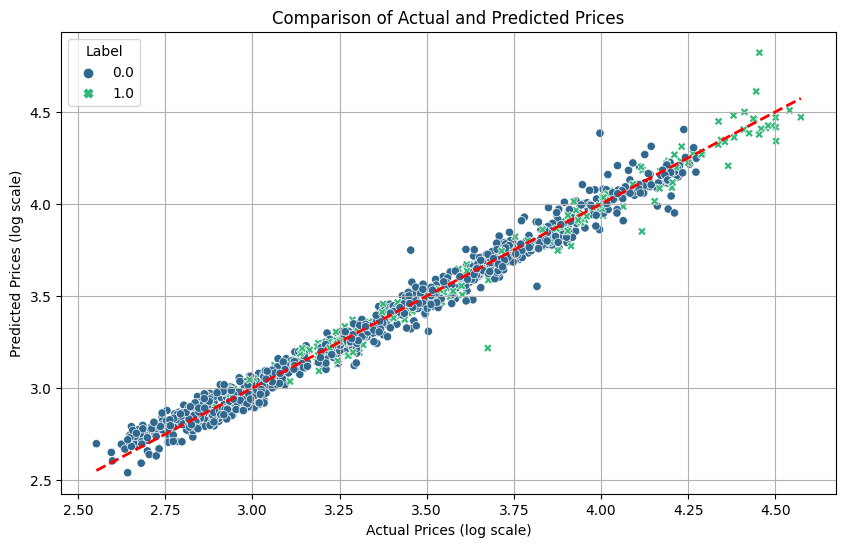

In [199]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_test and y_pred are already defined from your previous model evaluation
# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
# sns.scatterplot(x=y_test, y=y_pred)

# Create a DataFrame to make plotting easier
test_predictions = pd.DataFrame({
    'Actual Prices': y_test,
    'Predicted Prices': y_pred,
    'Label': X_test[:, -1]  # Assuming the label data is kept in X_test
})

sns.scatterplot(x='Actual Prices', y='Predicted Prices', hue='Label', data=test_predictions, palette='viridis', style='Label')
plt.title('Comparison of Actual and Predicted Prices')
plt.xlabel('Actual Prices (log scale)')
plt.ylabel('Predicted Prices (log scale)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Add a reference line
plt.grid(True)
plt.show()


In [81]:
# Assuming you already have y_test and y_pred from the previous steps
# Create a DataFrame to compare actual vs predicted values
comparison_df = pd.DataFrame({'Actual Price': y_test, 'Predicted Price': y_pred})

# Reset index if y_test is a pandas Series with an index that doesn't start from 0
comparison_df.reset_index(drop=True, inplace=True)

# Sample 10 random rows from the DataFrame for a quick assessment
sample_comparison_df = comparison_df.sample(n=10, random_state=42)  # Use a fixed random state for reproducibility

print("Sample of Test Set Predictions:")
print(sample_comparison_df)


Sample of Test Set Predictions:
     Actual Price  Predicted Price
453      3.539202         3.653828
792      4.253265         4.247902
209      3.720738         3.653302
309      4.005567         4.078380
739      3.227887         3.219076
578      3.701827         3.697075
850      3.713154         3.685641
545      3.540079         3.518226
436      2.762679         2.724338
677      3.456062         3.446929


In [106]:
# Get all the results from the grid search
results = pd.DataFrame(grid_search.cv_results_)

# Select relevant columns to display
relevant_columns = ['param_sgdregressor__loss', 'param_sgdregressor__penalty', 'param_sgdregressor__alpha',
                    'param_sgdregressor__l1_ratio', 'param_sgdregressor__learning_rate', 'param_sgdregressor__eta0',
                    'param_sgdregressor__max_iter', 'param_sgdregressor__tol', 'param_sgdregressor__epsilon',
                    'mean_test_score', 'std_test_score', 'rank_test_score']

# Display these columns for an overview of performance across different hyperparameter combinations
# display()


for col in relevant_columns:
    print(f"{col}: {results.loc[results.rank_test_score < 180 ].groupby([col])[['mean_test_score', 'rank_test_score']].min()}")

param_sgdregressor__loss:                           mean_test_score  rank_test_score
param_sgdregressor__loss                                  
squared_error                    -0.00351                1
param_sgdregressor__penalty:                              mean_test_score  rank_test_score
param_sgdregressor__penalty                                  
l1                                  -0.00351                1
param_sgdregressor__alpha:                            mean_test_score  rank_test_score
param_sgdregressor__alpha                                  
0.0005                           -0.003391                1
0.0010                           -0.003422                2
0.0020                           -0.003510                5
param_sgdregressor__l1_ratio:                               mean_test_score  rank_test_score
param_sgdregressor__l1_ratio                                  
0.1                                  -0.00351                1
param_sgdregressor__learning_rate:  

In [17]:
# RF

# # Define a grid of hyperparameters to search over
# param_grid = {
#     'n_estimators': [100, 200],  # Number of trees in the forest
#     'max_depth': [None, 10, 20],  # Maximum depth of the tree
#     'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2]  # Minimum number of samples required to be at a leaf node
# }

# # Setup the grid search
# sgd_model = joblib.load('models/sgd_model.joblib')

# model = sgd_model
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Retrieve the best model from grid search
# best_model = grid_search.best_estimator_

# # Predict on the testing set
# y_pred = best_model.predict(X_test)

# # Calculate metrics
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred)

# print(f"Root Mean Squared Error: {rmse}")
# print(f"R^2 Score: {r2}")



### 5. Discussions on Potential Production Issues

- **Objective**: Discuss potential challenges in deploying the model and maintaining its performance over time.
- **Subsections**:
  - **Model Drift**: What it is, how it can be detected, and strategies for mitigation.
  - **Retraining Strategies**: Options for retraining the model, including triggers for retraining and methods (e.g., online learning, batch retraining).
  - **Scalability and Efficiency**: Issues related to scaling the model for production, handling large data volumes.
  - **Monitoring and Logging**: Strategies for monitoring model performance in production and logging necessary information for audits and improvements.


In [9]:
# Utils

# Assuming the preprocessor and model are saved in the 'models/' directory.
PREPROCESSOR_PATH = 'models/preprocessor.joblib'
MODEL_PATH = 'models/trained_model.joblib'

def load_resources():
    preprocessor = joblib.load(PREPROCESSOR_PATH)
    model = joblib.load(MODEL_PATH)
    return preprocessor, model

def predict_price(features_raw):
    preprocessor, model = load_resources()
    
    # Transform features_raw into a DataFrame if it's not already
    if not isinstance(features_raw, pd.DataFrame):
        features_raw = pd.DataFrame(features_raw, index=[0])
    
    features_preprocessed = preprocessor.transform(features_raw)
    prediction = model.predict(features_preprocessed)
    return prediction